# Lecture 4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions

# Breaking Example  - Samples from prior predictive
---

Text(0.5, 1.0, 'Prior predicitve')

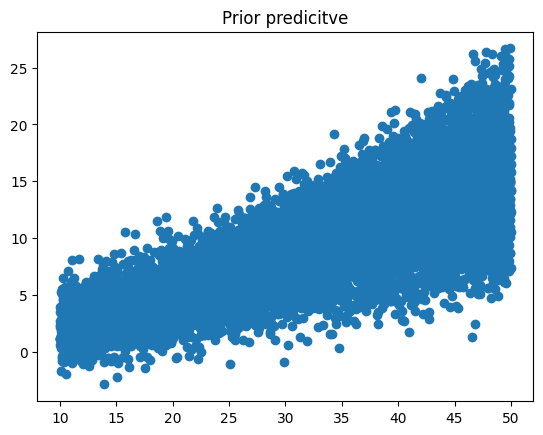

In [15]:
## breaking example
# x_i speed y_i breaking distance
# Model: y_i|x_i, a, ,b, d ~ N(a x_i + b x_i^2, d^2)
# a, b, d Uniform priors

xrange = [10, 50]
prior_params = [0.1, 0.3, 0.0, 0.005, 0.5, 2.]
N_sims = 10000

a = np.random.uniform(prior_params[0],prior_params[1], N_sims)
b = np.random.uniform(prior_params[2],prior_params[3], N_sims)
d = np.random.uniform(prior_params[4],prior_params[5], N_sims)

results = pd.DataFrame()
results['x'] = np.random.uniform(xrange[0], xrange[1], N_sims)
results['y'] = np.random.normal(loc=(a*results['x'] + b*results['x']**2), scale=d)

plt.plot(results['x'], results['y'], 'o')
plt.title('Prior predicitve')


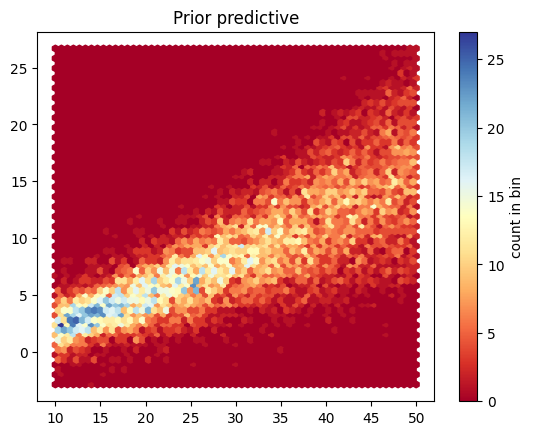

In [29]:
# smooth plot

plt.hexbin(results['x'], results['y'], gridsize=60, cmap='RdYlBu')
cb = plt.colorbar(label='count in bin')
plt.title('Prior predictive')
plt.show()

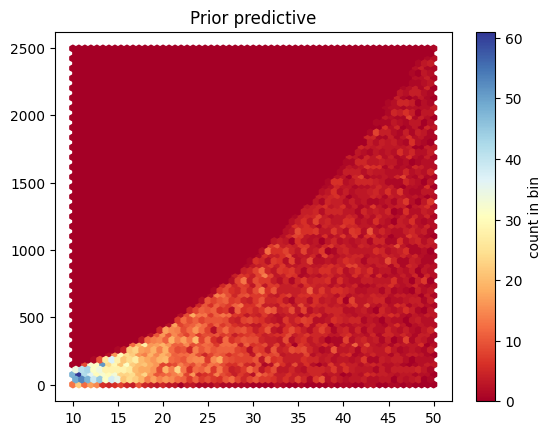

In [35]:
# look at the plot - is this reasonable? 
# we dont have y's in the 2500 range so we can conlude that this is not a reasonable prior
# We also have 0 breaking distance at 50km/h -- this is unreasonable

xrange = [10, 50]
prior_params = [0., 1., 0.0, 1., 0., 1.]
N_sims = 10000

a = np.random.uniform(prior_params[0],prior_params[1], N_sims)
b = np.random.uniform(prior_params[2],prior_params[3], N_sims)
d = np.random.uniform(prior_params[4],prior_params[5], N_sims)

results = pd.DataFrame()
results['x'] = np.random.uniform(xrange[0], xrange[1], N_sims)
results['y'] = np.random.normal(loc=(a*results['x'] + b*results['x']**2), scale=d)

plt.hexbin(results['x'], results['y'], gridsize=60, cmap='RdYlBu')
cb = plt.colorbar(label='count in bin')
plt.title('Prior predictive')
plt.show()

# Monte Carlo Integration. Alternative Problem - Want to compute probabilities pi(y) for different values of y.
---
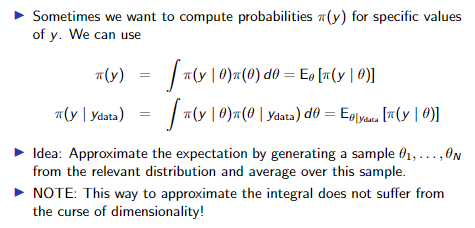

y is fixed then

p(y|theta) is a function of theta
p(theta | y_data) is a distribution of theta

then the integral has the form of an expectation.

### binomial example - beta prior (conjugate)
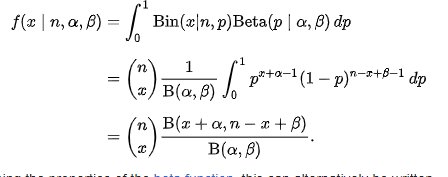

In [93]:
# binomial example - beta prior (conjugate)
# asusme posterior Beta(7.3, 11.9) after som observations
# Question to answer: prob of 2 success out 7?
N = 10000
total_count = 7
posterior = tfd.BetaBinomial(7, 7.3, 11.9)
#samples = posterior.sample(N)

true = posterior.prob(2).numpy()
print('True probabaility:',true)

#simulation approach
theta = tfd.Beta(7.3, 11.9).sample(N)
samples = tfd.Binomial(total_count=total_count, probs=theta).sample()
print('Simulation based estimate of probabaility:', np.sum(samples == 2.0)/len(samples)) 
print(' std:',  np.std(samples))
print(' what does the standard deviation even mean in this case?')

#monte carlo integration
theta = tfd.Beta(7.3, 11.9).sample(N)
print('Monte Carlo integration:', np.mean(tfd.Binomial(total_count=total_count, probs=theta).prob(2)))
print(' std:', np.std(tfd.Binomial(total_count=total_count, probs=theta).prob(2)))
print(' MC is more stable/"efficient"')


True probabaility: 0.24906358
Simulation based estimate of probabaility: 0.2449
 std: 1.4632756
 what does the standard deviation even mean in this case?
Monte Carlo integration: 0.24918394
 std: 0.06933497
 MC is more stable/"efficient"


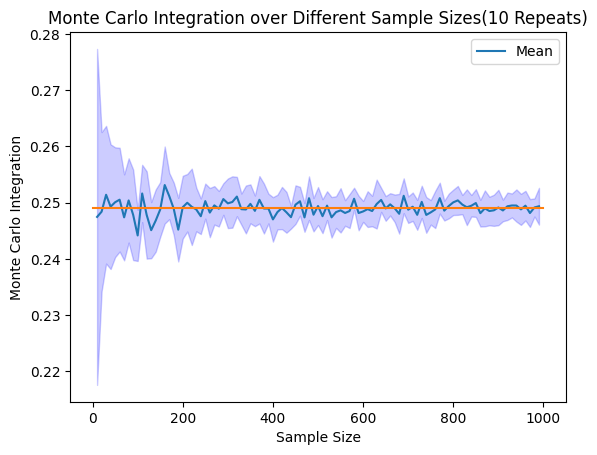

In [95]:
# inefficient and wrong probably

range_ = list(range(10, 1000, 10))
mci_repeats = pd.DataFrame()
for r in range(10):
    mci = []
    for n in range_:
        theta = tfd.Beta(7.3, 11.9).sample(n)
        mci.append(np.mean(tfd.Binomial(total_count=total_count, probs=theta).prob(2)))
        #np.std(tfd.Binomial(total_count=total_count, probs=theta).prob(2)))
    mci_repeats.loc[:, r] = mci

mean_mci = mci_repeats.mean(axis=1)
std_mci = mci_repeats.std(axis=1)

plt.plot(range_, mean_mci, label='Mean')
plt.fill_between(range_, mean_mci-std_mci, mean_mci+std_mci, color='b', alpha=0.2)
plt.plot([0, 1000], [true, true])

plt.xlabel('Sample Size')
plt.ylabel('Monte Carlo Integration')
plt.title('Monte Carlo Integration over Different Sample Sizes(10 Repeats)')
plt.legend()
plt.show()

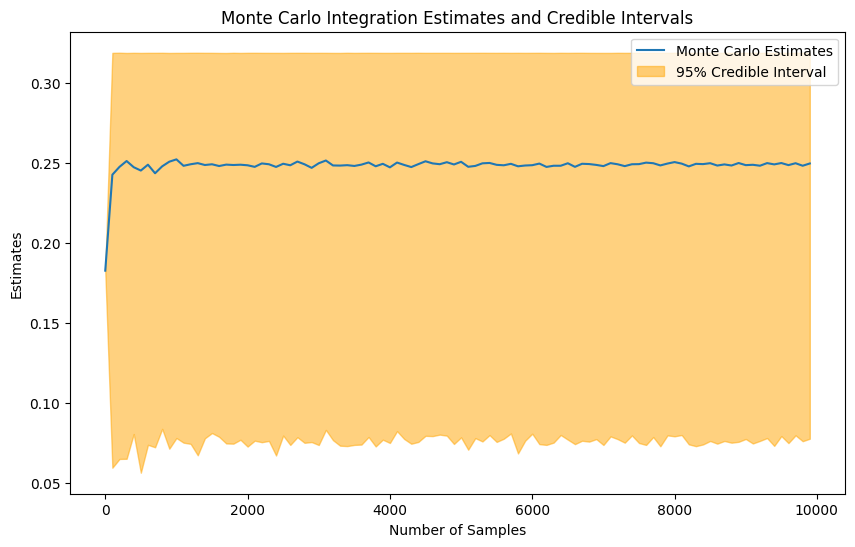

In [107]:
# wrong! why?

# more efficient (and correct Q???) to use credible interval

range_ = list(range(1, 10000, 100))
mci = []
credible_intervals = []

for n in range_:
    theta = tfd.Beta(7.3, 11.9).sample(n)
    mci.append(np.mean(tfd.Binomial(total_count=total_count, probs=theta).prob(2)))
    
    probs = tfd.Binomial(total_count=total_count, probs=theta).prob(2)
    credible_intervals.append((np.percentile(probs, 2.5), np.percentile(probs, 97.5))) #these are not right. These are of the parameter

lower_bounds = [interval[0] for interval in credible_intervals]
upper_bounds = [interval[1] for interval in credible_intervals]

plt.figure(figsize=(10, 6))
plt.plot(range_, mci, label='Monte Carlo Estimates')
plt.fill_between(range_, lower_bounds, upper_bounds, color='orange', alpha=0.5, label='95% Credible Interval')
plt.xlabel('Number of Samples')
plt.ylabel('Estimates')
plt.title('Monte Carlo Integration Estimates and Credible Intervals')
plt.legend()
plt.show()



C:\Users\isacb\AppData\Local\Temp\ipykernel_2116\2867739060.py:19: RuntimeWarning: invalid value encountered in sqrt
  upper = msamp + 1.96*np.sqrt(varsamp/np.arange(1, n+1))
C:\Users\isacb\AppData\Local\Temp\ipykernel_2116\2867739060.py:20: RuntimeWarning: invalid value encountered in sqrt
  lower = msamp - 1.96*np.sqrt(varsamp/np.arange(1, n+1))


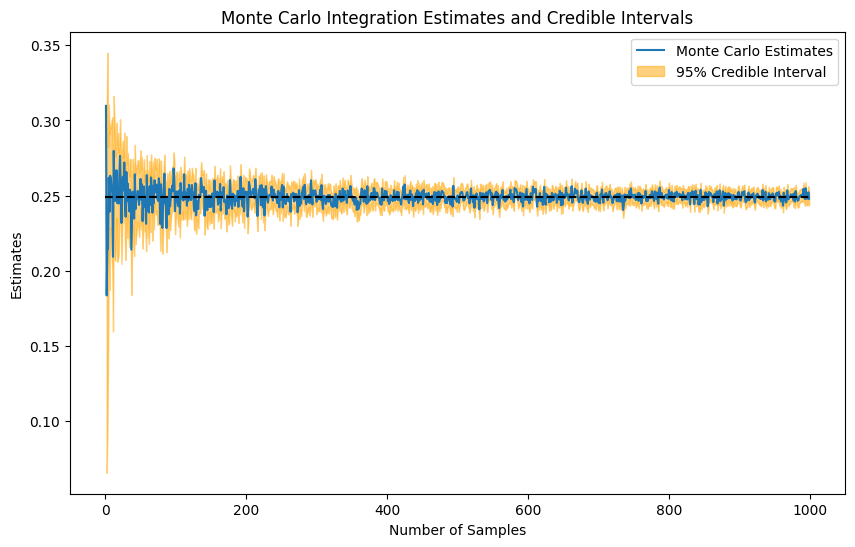

In [117]:
# range of values to calculate
range_ = list(range(1, 1000))

# list to store Monte Carlo estimates and credible intervals
mci = []
upper_bounds = []
lower_bounds = []

for n in range_:
    theta = tfd.Beta(7.3, 11.9).sample(n)
    probs = tfd.Binomial(total_count=total_count, probs=theta).prob(2)

    # Monte Carlo estimate
    mci.append(np.mean(probs))

    # Cumulative estimate and credible intervals
    msamp = np.cumsum(probs) / np.arange(1, n+1)
    varsamp = (np.cumsum(probs**2) - np.arange(1, n+1) * msamp**2) / np.concatenate(([1], np.arange(1, n)))
    upper = msamp + 1.96*np.sqrt(varsamp/np.arange(1, n+1))
    lower = msamp - 1.96*np.sqrt(varsamp/np.arange(1, n+1))
    
    # last elements of upper and lower as these will be the estimate for this sample size
    upper_bounds.append(upper[-1])
    lower_bounds.append(lower[-1])

plt.figure(figsize=(10, 6))
plt.plot(range_, mci, label='Monte Carlo Estimates')
plt.fill_between(range_, lower_bounds, upper_bounds, color='orange', alpha=0.5, label='95% Credible Interval')
plt.plot([0,1000], [true, true], 'k',ls='--')
plt.xlabel('Number of Samples')
plt.ylabel('Estimates')
plt.title('Monte Carlo Integration Estimates and Credible Intervals')
plt.legend()
plt.show()

#### Next, This is the correct

above is correct however to get a smooth plot we need to append/cummulate samples rather than drawing all new

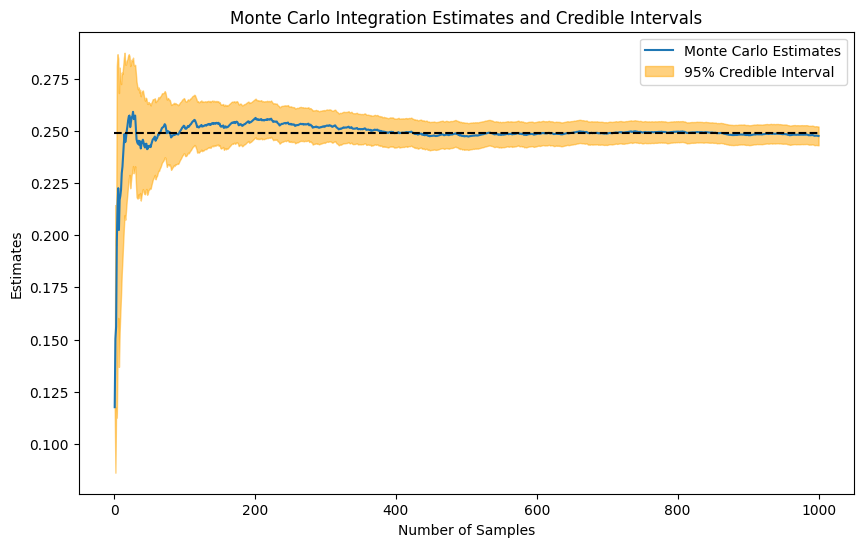

In [121]:
# range of values to calculate
max_n = 1000
range_ = list(range(1, max_n+1))

# list to store Monte Carlo estimates and credible intervals
mci = []
upper_bounds = []
lower_bounds = []

# generate all samples at once
theta = tfd.Beta(7.3, 11.9).sample(max_n)
probs = tfd.Binomial(total_count=total_count, probs=theta).prob(2)

for n in range_:
    probs_n = probs[:n]

    # Monte Carlo estimate
    mci.append(np.mean(probs_n))

    # Cumulative estimate and credible intervals
    msamp = np.cumsum(probs_n) / np.arange(1, n+1)
    varsamp = (np.cumsum(probs_n**2) - np.arange(1, n+1) * msamp**2) / np.concatenate(([1], np.arange(1, n)))
    upper = msamp + 1.96*np.sqrt(varsamp/np.arange(1, n+1))
    lower = msamp - 1.96*np.sqrt(varsamp/np.arange(1, n+1))
    
    # last elements of upper and lower as these will be the estimate for this sample size
    upper_bounds.append(upper[-1])
    lower_bounds.append(lower[-1])

plt.figure(figsize=(10, 6))
plt.plot(range_, mci, label='Monte Carlo Estimates')
plt.fill_between(range_, lower_bounds, upper_bounds, color='orange', alpha=0.5, label='95% Credible Interval')
plt.plot([0,max_n], [true, true], 'k',ls='--')
plt.xlabel('Number of Samples')
plt.ylabel('Estimates')
plt.title('Monte Carlo Integration Estimates and Credible Intervals')
plt.legend()
plt.show()

# Rejection sampling
----

- Monte Carlo method
- We cannot simulate from f(x), but we can simulate from an "instrumental" dens. g(x) that approximates f(x)

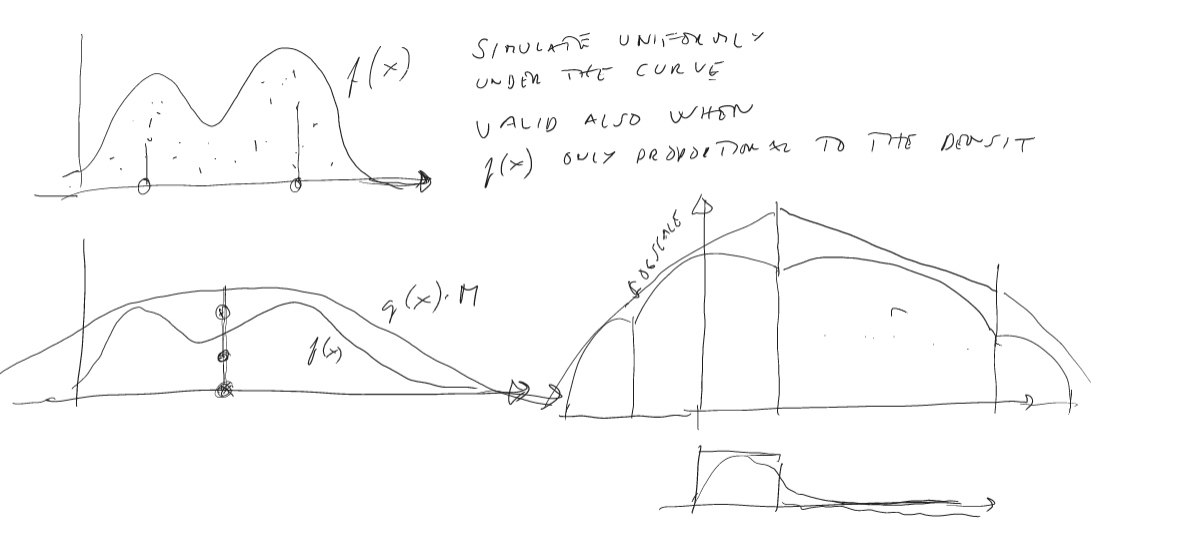

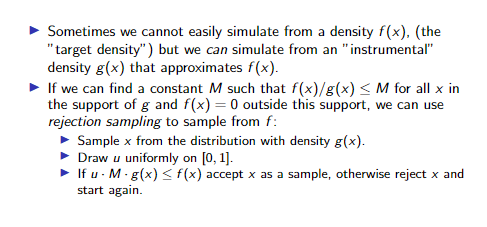

10000 accepted samples out of 32049


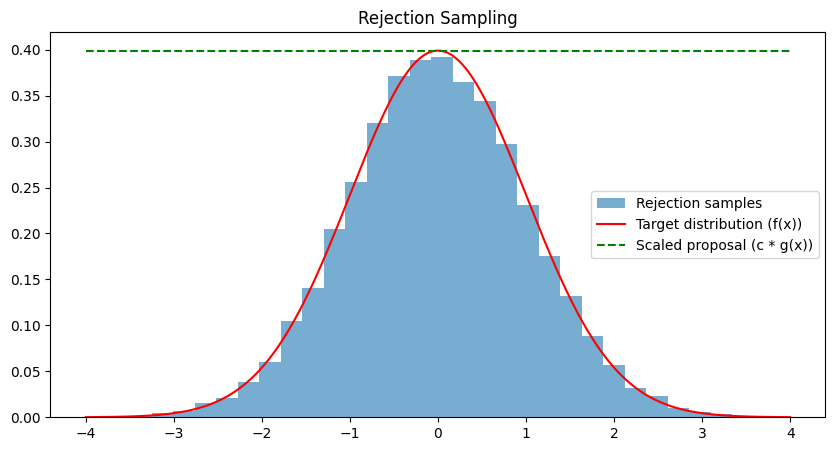

In [9]:
from scipy.stats import norm

# Target distribution
target = norm()

# Proposal distribution
proposal = lambda x: np.ones_like(x)

# Constants for proposal distribution
x = np.linspace(-4, 4, 1000)
c = np.max(target.pdf(x) / proposal(x))

# Rejection sampling
N = 10000
samples = []
counter = 0

while len(samples) < N:
    z = np.random.uniform(-4, 4)  # proposal sample
    u = np.random.uniform(0, c * proposal(z))  # uniform sample
    counter+=1
    if u <= target.pdf(z):  # if under target pdf, accept the sample
        samples.append(z)

samples = np.array(samples)

print(f'{len(samples)} accepted samples out of {counter}')
# Plotting
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=30, density=True, alpha=0.6, label='Rejection samples')
plt.plot(x, target.pdf(x), 'r-', label='Target distribution (f(x))')
#plt.plot(x, proposal(x), 'b-', label='Proposal distribution (g(x))')
plt.plot(x, c*proposal(x), 'g--', label='Scaled proposal (c * g(x))')
plt.legend()
plt.title("Rejection Sampling")
plt.show()